# CS6700: Reinforcement Learning
## Programming Assignment 3

Submitted by:
- Archish S (ME20B032)
- Vinayak Gupta (EE20B152)

# Semi-Markov Decision Process

## Imports

In [ ]:
import io
import glob
import random
import pickle
from dataclasses import dataclass
from collections import deque
from itertools import count

import gym
from gym import wrappers
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 10
})
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
%config InlineBackend.figure_format = 'retina'

import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Environment

In [ ]:
env = gym.make('Taxi-v3')
state = env.reset()

# Current State
print("Current State:", env.s)

# Observation Space
locations = ["Red", "Green", "Yellow", "Blue", "Taxi"]
print ("Number of states:", env.observation_space.n)

# Action Space
actions = ["south", "north", "east", "west", "pick", "drop"]
print ("Number of actions:", env.action_space.n)

# Transition 
action = random.randint(0, len(actions)-1)
next_state, reward, done, info = env.step(action)
print("Action:", actions[action])
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)

print("Decoded Current State:", list(env.decode(state)))
print("Decoded Next State:", list(env.decode(next_state)))

In [ ]:
def get_grid():
    plt.figure(figsize=(5, 5))
    grid = np.zeros((5, 5)).astype(int)
    grid[0, 0] = 1
    grid[0, 4] = 2
    grid[4, 0] = 3
    grid[4, 3] = 4

    colors = ['white', 'red', 'green', 'yellow', 'blue']
    cmap = plt.cm.colors.ListedColormap(colors)

    plt.imshow(grid, cmap=cmap, interpolation='nearest', alpha=0.5)

    plt.axvline(x=0.5, ymin=0, ymax=2/5, color='black', linewidth=2)
    plt.axvline(x=2.5, ymin=0, ymax=2/5, color='black', linewidth=2)
    plt.axvline(x=1.5, ymin=3/5, ymax=1, color='black', linewidth=2)
    plt.axvline(x=0.5, color='black', linewidth=0.25)
    plt.axvline(x=1.5, color='black', linewidth=0.25)
    plt.axvline(x=2.5, color='black', linewidth=0.25)
    plt.axvline(x=3.5, color='black', linewidth=0.25)
    plt.axvline(x=4.5, color='black', linewidth=0.25)

    plt.axhline(y=0.5, color='black', linewidth=0.25)
    plt.axhline(y=1.5, color='black', linewidth=0.25)
    plt.axhline(y=2.5, color='black', linewidth=0.25)
    plt.axhline(y=3.5, color='black', linewidth=0.25)
    plt.axhline(y=4.5, color='black', linewidth=0.25)

    plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

## Parameters

In [26]:
max_runs = 5

max_episodes = 10000
max_steps = 1000
max_optsteps = 500

epsilon_max = 0.1
epsilon_min = 1e-4

gamma = 0.9
alpha = 0.25

nX = 5; nY = 5; nPas = 5; nDrop = 4
nS = nX * nY * nPas * nDrop

targets = {0: [0, None], 1: [None, 4], 2: [4, None], 3: [None, 0], 4: [2, 2]}
actions_map = {0: "\u2193", 1: "\u2191", 2: "\u2192", 3: "\u2190", 4: "P", 5: "D", 6: "Top", 7: "Right", 8: "Bottom", 9: "Left", 10: "Centre"}
nO = 5
nA = 6

assert nS == env.observation_space.n
assert nA == env.action_space.n

## Policy

In [ ]:
def egreedy_policy(q_values, state, epsilon):
    if q_values[state].any() and random.random() > epsilon:
        return np.argmax(q_values[state])

    choice = random.randint(0, q_values.shape[-1] - 1)  
    return choice

In [ ]:
def substate(state):
    x, y, _, _ = env.decode(state)
    return x * nX + y

In [ ]:
# def Option(env, state, Q, goal, epsilon=0.1):
#     optdone, optact = False, None
#     x, y, pas, drop = env.decode(state)

#     if (x == targets[goal][0] and y == targets[goal][1]):
#         optdone = True 
#         if pas == goal:
#             optact = 4
#         elif drop == goal:
#             optact = 5 
#         else:   
#             optact = 1 if (goal in [0, 1]) else 0
#     else:
#         option_state = substate(state)
#         optact = egreedy_policy(Q, option_state, epsilon=epsilon) 

#     return [optact, optdone]

# SMDP Q-Learning

In [ ]:
Q_SMDP = np.zeros((max_runs, nS, nA + nO))
Q_SMDP_Options = dict([(i, np.zeros((max_runs, nX * nY, nA - 2))) for i in range(nO)])

updates_SMDP = []

run_rewards_SMDP = []
for run in range(max_runs):

    episode_updates = []
    episode_rewards = []
    for episode in range(max_episodes):
        state = env.reset()
        done = False
        
        step_updates = 0
        step_rewards = 0
        step = 0
        while not done:
            epsilon = max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * episode / max_episodes)

            action = egreedy_policy(Q_SMDP[run], state, epsilon=epsilon)

            if action in [0, 1, 2, 3, 4, 5]:
                next_state, reward, done, info = env.step(action)

                Q_SMDP[run, state, action] = Q_SMDP[run, state, action] + alpha * (reward + gamma * np.max(Q_SMDP[run, next_state]) - Q_SMDP[run, state, action])
                
                step_rewards += reward
                step_updates += 1
                step += 1

                state = next_state

            else:
                start = state
                goal = action - 6

                optrewards = []
                optdone, optsteps = False, 0

                x, y, _, _ = env.decode(state)

                end_x, end_y = targets[goal]
                if end_x is None and y == end_y:
                    optdone = True
                    optrewards = [0]
                elif end_y is None and x == end_x:
                    optdone = True
                    optrewards = [0]
                elif x == end_x and y == end_y:
                    optdone = True
                    optrewards = [0]

                while not optdone:

                    optact = egreedy_policy(Q_SMDP_Options[goal][run], substate(state), epsilon=epsilon)
                    next_state, reward, done, info = env.step(optact)
                    x, y, _, _ = env.decode(next_state)

                    end_x, end_y = targets[goal]
                    if end_x is None and y == end_y:
                        optreward = 0
                        optdone = True
                    elif end_y is None and x == end_x:
                        optreward = 0
                        optdone = True
                    elif x == end_x and y == end_y:
                        optreward = 0
                        optdone = True
                    else:
                        optreward = reward

                    Q_SMDP_Options[goal][run, substate(state), optact] = Q_SMDP_Options[goal][run, substate(state), optact] + alpha * (optreward + gamma * np.max(Q_SMDP_Options[goal][run, substate(next_state)]) - Q_SMDP_Options[goal][run, substate(state), optact])

                    optrewards.append(gamma**optsteps * reward)
                    optsteps += 1
                    
                    state = next_state
                    if optsteps >= max_optsteps:
                        break

                if optdone:
                    optrewards = sum(optrewards)
                    Q_SMDP[run, start, action] = Q_SMDP[run, start, action] + alpha * (optrewards + gamma**optsteps * np.max(Q_SMDP[run, next_state]) - Q_SMDP[run, start, action])

                step_rewards += optrewards
                step_updates += 1
                step += optsteps

            if step >= max_steps:
                break

        episode_rewards.append(step_rewards)
        episode_updates.append(step_updates)

        clear_output(wait=True)
        print(f"Run: {run+1}/{max_runs}, Episode: {episode+1}/{max_episodes}: Reward: {step_rewards}")

        env.close()
        

    run_rewards_SMDP.append(episode_rewards)
    updates_SMDP.append(episode_updates)

Q_SMDP = np.mean(Q_SMDP, axis=0)
Q_SMDP_Options = dict([(i, np.mean(Q_SMDP_Options[i], axis=0)) for i in range(nO)])

with open(f"runs/Q_SMDP_Alternate.pkl", "wb") as f:
    pickle.dump(Q_SMDP, f)

with open(f"runs/Q_SMDP_Options_Alternate.pkl", "wb") as f:
    pickle.dump(Q_SMDP_Options, f)

with open(f"runs/Rewards_SMDP_Alternate.pkl", "wb") as f:
    pickle.dump(run_rewards_SMDP, f)

with open(f"runs/Updates_SMDP_Alternate.pkl", "wb") as f:
    pickle.dump(updates_SMDP, f)

In [ ]:
# state = env.reset()

# x, y, pas_start, drop_start = env.decode(state)

# done = False
# pick_trajectory = [(x, y)]
# drop_trajectory = []

# while not done:
#     action = np.argmax(Q_SMDP[state])
#     if action < 6:
#         next_state, reward, done, info = env.step(action)
        
#         x, y, pas, drop = env.decode(next_state)
        
#         if pas != 4:
#             pick_trajectory.append((x, y))
#         else:
#             drop_trajectory.append((x, y))


#         state = next_state

#     else:
#         goal = action - 6
#         optdone = False
#         while not optdone:
#             optact = np.argmax(Q_SMDP_Options[goal][substate(state)])
#             next_state, reward, done, info = env.step(optact)
#             # env.render()
#             x, y, pas, drop = env.decode(next_state)
#             if pas != 4:
#                 pick_trajectory.append((x, y))
#             else:
#                 drop_trajectory.append((x, y))
#             if x == targets[goal][0] and y == targets[goal][1]:
#                 optdone = True
#             state = next_state

# get_grid()
# pick_trajectory = np.array(pick_trajectory)
# drop_trajectory = np.array(drop_trajectory)

# pas_x, pas_y = targets[pas_start]
# plt.text(pas_y, pas_x, "Pick", fontsize=12, color='black', ha='center', va='center')
# drop_x, drop_y = targets[drop_start]
# plt.text(drop_y, drop_x, "Drop", fontsize=12, color='black', ha='center', va='center')

# start_x, start_y = pick_trajectory[0]
# plt.text(start_y, start_x, "Start", fontsize=12, color='black', ha='center', va='center')

# for i in range(1, len(pick_trajectory)-1):
#     plt.plot([pick_trajectory[i-1][1], pick_trajectory[i][1]], [pick_trajectory[i-1][0], pick_trajectory[i][0]], color='orange', linewidth=1, linestyle='dashed')
# for i in range(1, len(drop_trajectory)):
#     plt.plot([drop_trajectory[i-1][1], drop_trajectory[i][1]], [drop_trajectory[i-1][0], drop_trajectory[i][0]], color='magenta', linewidth=1, linestyle='dashed')

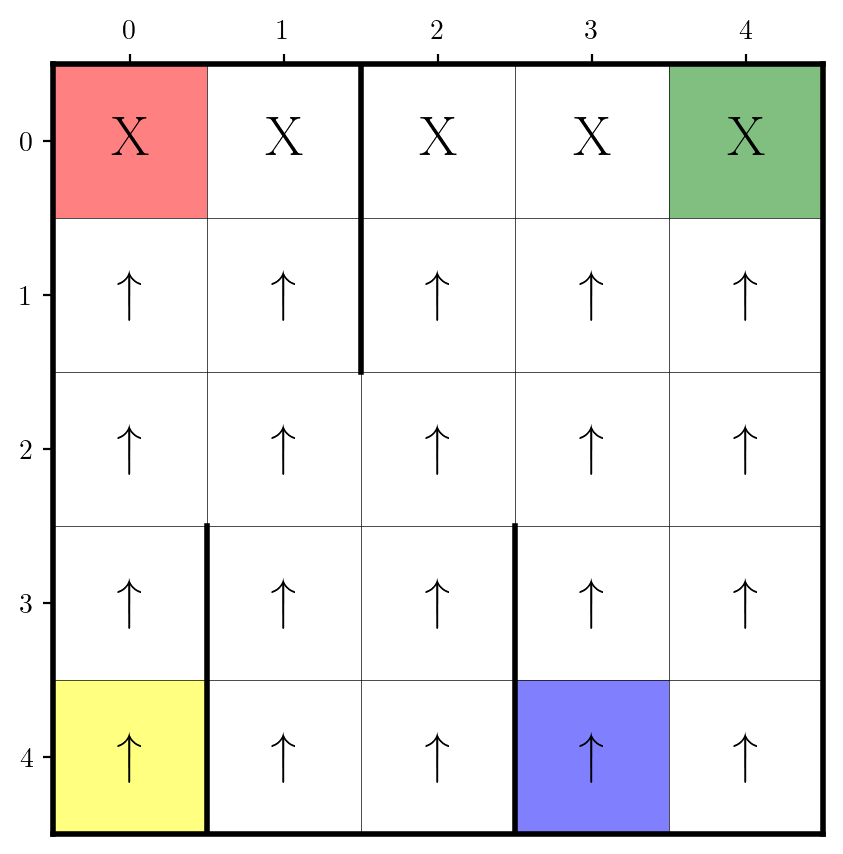

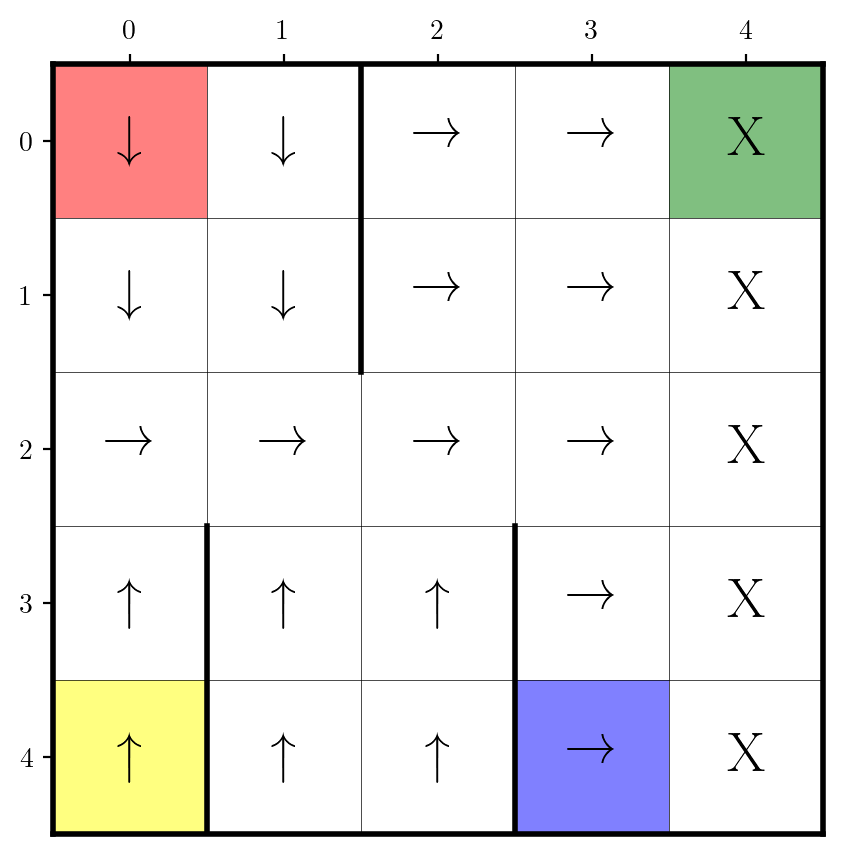

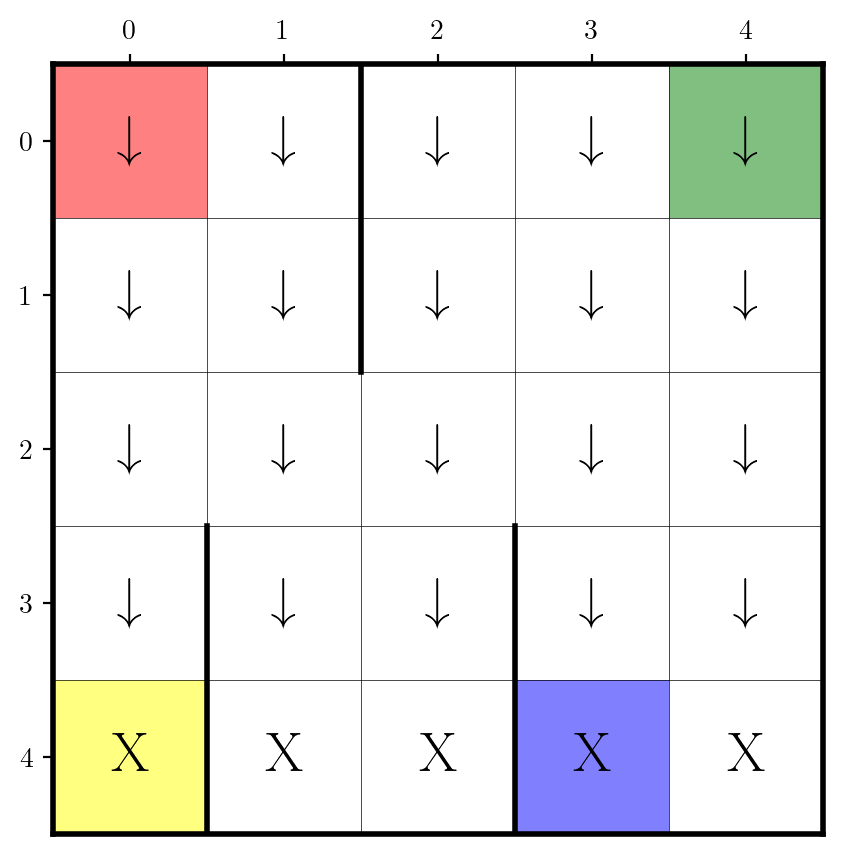

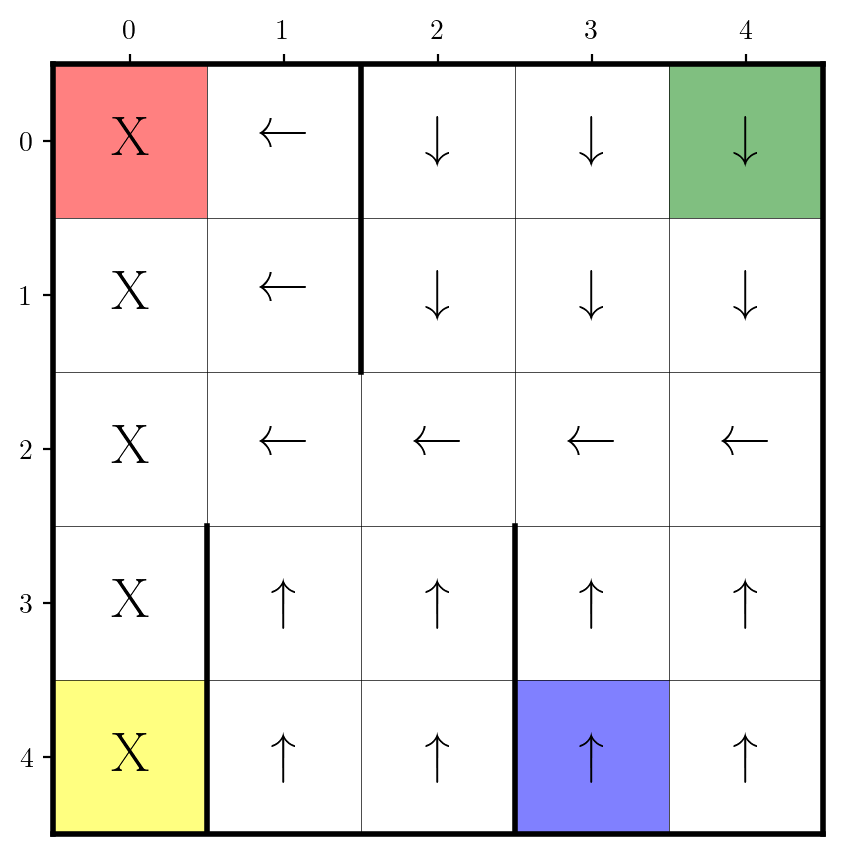

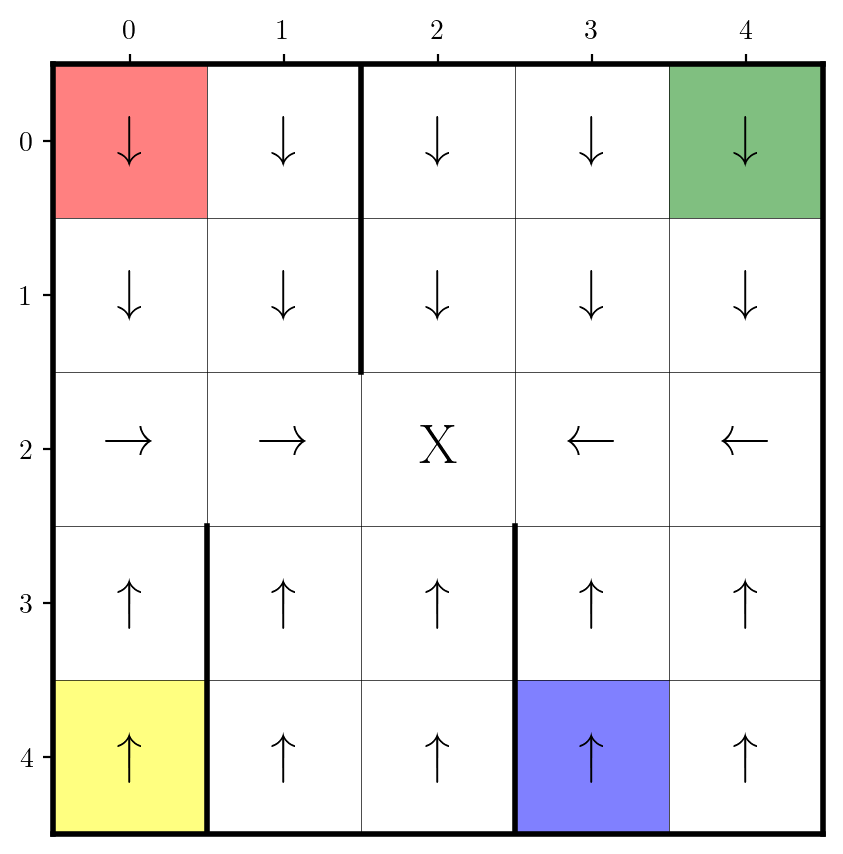

In [36]:
for goal in range(nO):
    plot_Q = Q_SMDP_Options[goal]
    get_grid()
    for i in range(nX):
        for j in range(nY):
            if targets[goal][0] is None and j == targets[goal][1]:
                plt.text(j, i, "X", ha='center', va='center', fontsize=20)
            elif targets[goal][1] is None and i == targets[goal][0]:
                plt.text(j, i, "X", ha='center', va='center', fontsize=20)
            elif i == targets[goal][0] and j == targets[goal][1]:
                plt.text(j, i, "X", ha='center', va='center', fontsize=20)
            else:
                action = np.argmax(plot_Q[i * nX + j])
                plt.text(j, i, actions_map[action], ha='center', va='center', fontsize=20)

    plt.savefig(f"Q_Options_A{goal}.pdf", bbox_inches='tight')

# Intra-Option Q-Learning

In [ ]:
Q_Intra = np.zeros((max_runs, nS, nO + nA))
Q_Intra_Options = dict([(i, np.zeros((max_runs, nX * nY, nA - 2))) for i in range(nO)])

updates_Intra = []
run_rewards_Intra = []
for run in range(max_runs):

    episode_updates = []
    episode_rewards = []
    for episode in range(max_episodes):
        state = env.reset()
        done = False
        
        step_updates = 0
        step_rewards = 0
        step = 0
        while not done:
            epsilon = max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * episode / max_episodes)

            action = egreedy_policy(Q_Intra[run], state, epsilon=epsilon)

            if action in [0, 1, 2, 3, 4, 5]:
                next_state, reward, done, info = env.step(action)
                x, y, _, _ = env.decode(next_state)

                Q_Intra[run, state, action] = Q_Intra[run, state, action] + alpha * (reward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, action])

                for G in range(nO):
                    if np.argmax(Q_Intra_Options[G][run, substate(state)]) != action:
                        continue
                    
                    end_x, end_y = targets[goal]
                    if end_x is None and y == end_y:
                        Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, G + 6])
                    elif end_y is None and x == end_x:
                        Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, G + 6])
                    elif x == end_x and y == end_y:
                        Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, G + 6])
                    else:
                        Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * Q_Intra[run, next_state, G + 6] - Q_Intra[run, state, G + 6])
                
                    step_updates += 1
                
                step_rewards += reward
                step_updates += 1
                step += 1

                state = next_state

            else:
                start = state
                goal = action - 6

                optrewards = []
                optdone, optsteps = False, 0

                x, y, _, _ = env.decode(state)
                
                end_x, end_y = targets[goal]
                if end_x is None and y == end_y:
                    optdone = True
                    optrewards = [0]
                elif end_y is None and x == end_x:
                    optdone = True
                    optrewards = [0]
                elif x == end_x and y == end_y:
                    optdone = True
                    optrewards = [0]

                while not optdone:
                    play = True

                    optact = egreedy_policy(Q_Intra_Options[goal][run], substate(state), epsilon=epsilon)
                    next_state, reward, done, info = env.step(optact)
                    x, y, _, _ = env.decode(next_state)

                    if x == targets[goal][0] and y == targets[goal][1]:
                        optreward = 0
                        optdone = True
                    else:
                        optreward = reward

                    Q_Intra_Options[goal][run, substate(state), optact] = Q_Intra_Options[goal][run, substate(state), optact] + alpha * (optreward + gamma * np.max(Q_Intra_Options[goal][run, substate(next_state)]) - Q_Intra_Options[goal][run, substate(state), optact])

                    Q_Intra[run, state, optact] = Q_Intra[run, state, optact] + alpha * (optreward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, optact])

                    for G in range(nO):
                        if np.argmax(Q_Intra_Options[G][run, substate(state)]) != optact and G != goal:
                            continue
                            
                        end_x, end_y = targets[goal]
                        if end_x is None and y == end_y:
                            Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, G + 6])
                        elif end_y is None and x == end_x:
                            Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, G + 6])
                        elif x == end_x and y == end_y:
                            Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * np.max(Q_Intra[run, next_state]) - Q_Intra[run, state, G + 6])
                        else:
                            Q_Intra[run, state, G + 6] = Q_Intra[run, state, G + 6] + alpha * (reward + gamma * Q_Intra[run, next_state, G + 6] - Q_Intra[run, state, G + 6])
                    
                        step_updates += 1

                    optrewards.append(gamma**optsteps * reward)
                    optsteps += 1
                    state = next_state
                    if optsteps >= max_optsteps:
                        break

                optrewards = sum(optrewards)
                step_rewards += optrewards
                step += optsteps
            
            if step >= max_steps:
                break


        episode_rewards.append(step_rewards)
        episode_updates.append(step_updates)

        clear_output(wait=True)
        print(f"Run: {run+1}/{max_runs}, Episode: {episode+1}/{max_episodes}: Reward: {step_rewards}")

        env.close()

    run_rewards_Intra.append(episode_rewards)
    updates_Intra.append(episode_updates)

Q_Intra = np.mean(Q_Intra, axis=0)
Q_Intra_Options = dict([(i, np.mean(Q_Intra_Options[i], axis=0)) for i in range(nO)])

with open(f"runs/Q_Intra_Alternate.pkl", "wb") as f:
    pickle.dump(Q_Intra, f)

with open(f"runs/Q_Intra_Options_Alternate.pkl", "wb") as f:
    pickle.dump(Q_Intra_Options, f)

with open(f"runs/Rewards_Intra_Alternate.pkl", "wb") as f:
    pickle.dump(run_rewards_Intra, f)

with open(f"runs/Updates_Intra_Alternate.pkl", "wb") as f:
    pickle.dump(updates_Intra, f)

In [ ]:
# state = env.reset()

# x, y, pas_start, drop_start = env.decode(state)

# done = False
# pick_trajectory = [(x, y)]
# drop_trajectory = []

# while not done:
#     action = np.argmax(Q_Intra[state])
#     if action < 6:
#         next_state, reward, done, info = env.step(action)
        
#         x, y, pas, drop = env.decode(next_state)
        
#         if pas != 4:
#             pick_trajectory.append((x, y))
#         else:
#             drop_trajectory.append((x, y))


#         state = next_state

#     else:
#         goal = action - 6
#         optdone = False
#         while not optdone:
#             optact = np.argmax(Q_Intra_Options[goal][substate(state)])
#             next_state, reward, done, info = env.step(optact)
#             # env.render()
#             x, y, pas, drop = env.decode(next_state)
#             if pas != 4:
#                 pick_trajectory.append((x, y))
#             else:
#                 drop_trajectory.append((x, y))
#             if x == targets[goal][0] and y == targets[goal][1]:
#                 optdone = True
#             state = next_state

# get_grid()
# pick_trajectory = np.array(pick_trajectory)
# drop_trajectory = np.array(drop_trajectory)

# pas_x, pas_y = targets[pas_start]
# plt.text(pas_y, pas_x, "Pick", fontsize=12, color='black', ha='center', va='center')
# drop_x, drop_y = targets[drop_start]
# plt.text(drop_y, drop_x, "Drop", fontsize=12, color='black', ha='center', va='center')

# start_x, start_y = pick_trajectory[0]
# plt.text(start_y, start_x, "Start", fontsize=12, color='black', ha='center', va='center')

# for i in range(1, len(pick_trajectory)-1):
#     plt.plot([pick_trajectory[i-1][1], pick_trajectory[i][1]], [pick_trajectory[i-1][0], pick_trajectory[i][0]], color='orange', linewidth=1, linestyle='dashed')
# for i in range(1, len(drop_trajectory)):
#     plt.plot([drop_trajectory[i-1][1], drop_trajectory[i][1]], [drop_trajectory[i-1][0], drop_trajectory[i][0]], color='magenta', linewidth=1, linestyle='dashed')

In [ ]:
for goal in range(nO):
    plot_Q = Q_Intra_Options[goal]
    get_grid()
    for i in range(nX):
        for j in range(nY):
            if i != targets[goal][0] or j != targets[goal][1]:
                action = np.argmax(plot_Q[i * nX + j])
                plt.text(j, i, actions_map[action], ha='center', va='center', fontsize=20)
            else:
                plt.text(j, i, "X", ha='center', va='center', fontsize=20)

---

In [33]:
mode = "Alternate"

with open(f"runs/Q_SMDP_{mode}.pkl", "rb") as f:
    Q_SMDP = pickle.load(f)

with open(f"runs/Q_SMDP_Options_{mode}.pkl", "rb") as f:
    Q_SMDP_Options = pickle.load(f)

with open(f"runs/Rewards_SMDP_{mode}.pkl", "rb") as f:
    rewards_SMDP = pickle.load(f)

with open(f"runs/Updates_SMDP_{mode}.pkl", "rb") as f:
    updates_SMDP = pickle.load(f)


with open(f"runs/Q_Intra_{mode}.pkl", "rb") as f:
    Q_Intra = pickle.load(f)

with open(f"runs/Q_Intra_Options_{mode}.pkl", "rb") as f:
    Q_Intra_Options = pickle.load(f)

with open(f"runs/Rewards_Intra_{mode}.pkl", "rb") as f:
    rewards_Intra = pickle.load(f)

with open(f"runs/Updates_Intra_{mode}.pkl", "rb") as f:
    updates_Intra = pickle.load(f)

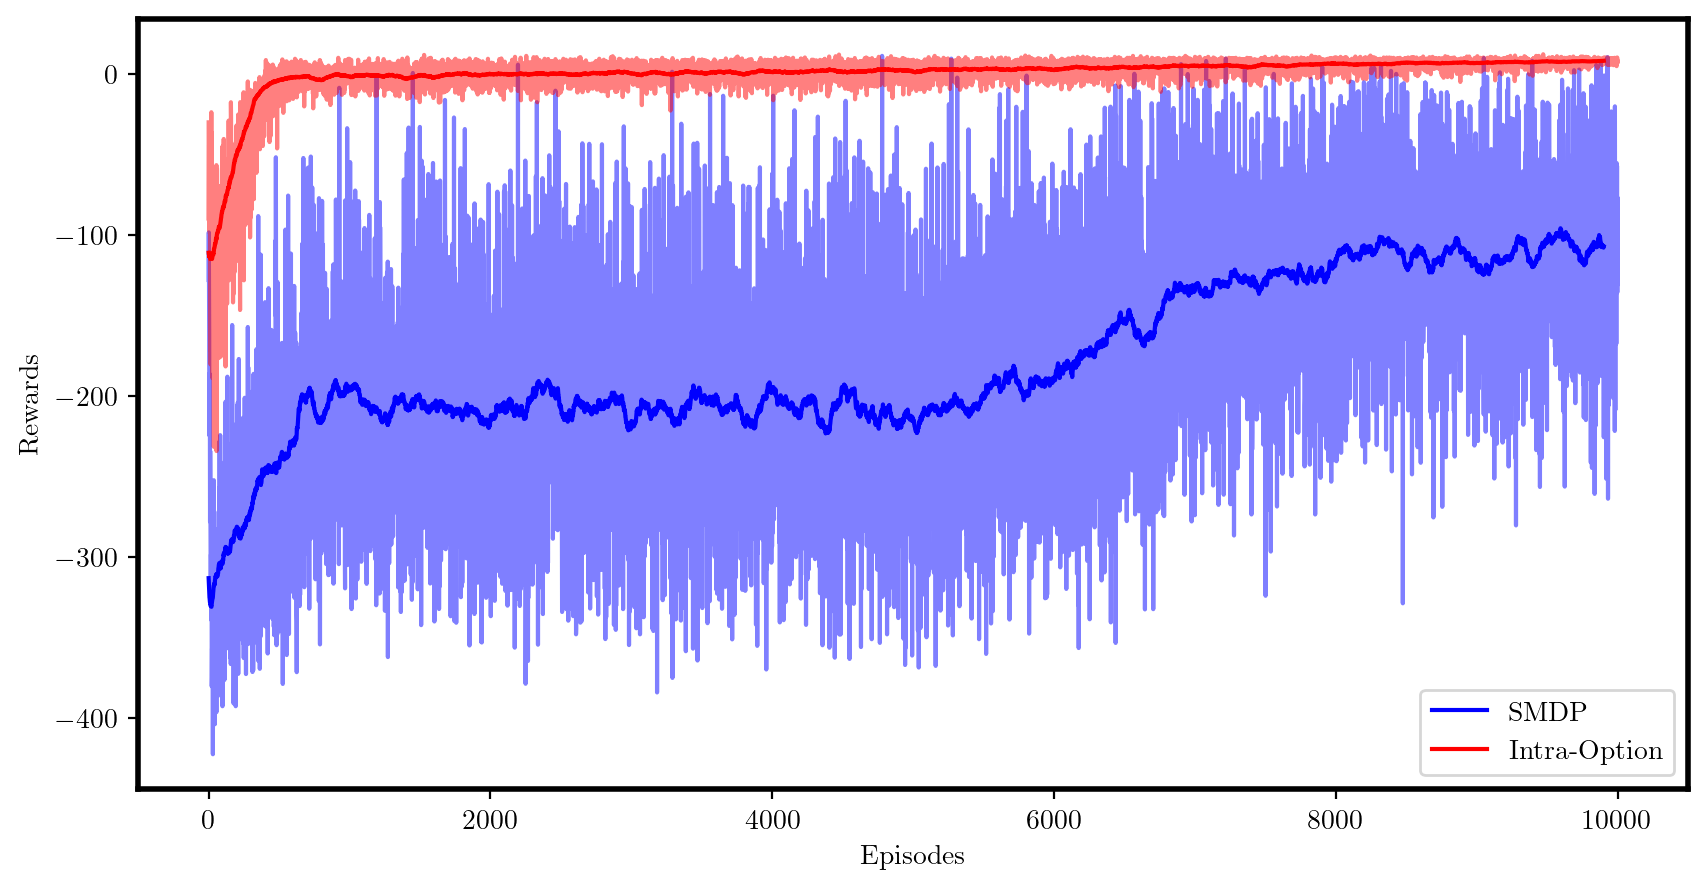

In [29]:
rewards_SMDP = np.mean(rewards_SMDP, axis=0)
rewards_Intra = np.mean(rewards_Intra, axis=0)

plt.figure(figsize=(10, 5))

window = 100
mean_SMDP = np.convolve(rewards_SMDP, np.ones(window), mode='valid') / window
mean_Intra = np.convolve(rewards_Intra, np.ones(window), mode='valid') / window

plt.plot(rewards_SMDP, color='blue', alpha=0.5)
plt.plot(mean_SMDP, label="SMDP", color='blue')

plt.plot(rewards_Intra, color='red', alpha=0.5)
plt.plot(mean_Intra, label="Intra-Option", color='red')

plt.xlabel("Episodes")
plt.ylabel("Rewards")

plt.legend()
plt.savefig(f"plots/rewards_alternate.pdf", bbox_inches='tight')

In [ ]:
# fig = plt.subplots(figsize=(10, 5))
# ax = plt.subplot(111)

# update_SMDP_freq = [0] * max_episodes
# update_intra_freq = [0] * max_episodes
# for episode in range(max_episodes):
#     for run in range(max_runs):
#         update_SMDP_freq[episode] += updates_SMDP[run][episode] / max_runs
#         update_intra_freq[episode] += updates_Intra[run][episode] / max_runs

# rolling_update_SMDP = np.convolve(update_SMDP_freq, np.ones(window), 'valid') / window
# rolling_update_intra = np.convolve(update_intra_freq, np.ones(window), 'valid') / window

# plt.plot(rolling_update_SMDP, label="SMDP", color='blue')
# plt.plot(rolling_update_intra, label="Intra-Option", color='red')

# plt.xlabel("Episodes")
# plt.ylabel("Updates")

# plt.legend()
# ax.set_ylim(-25, max([max(rolling_update_SMDP), max(rolling_update_intra)])+100)
# ax.set_ylim(-25, max([max(rolling_update_SMDP), max(rolling_update_intra)])+100)
# plt.savefig("plots/updates_010.pdf", bbox_inches='tight')

---

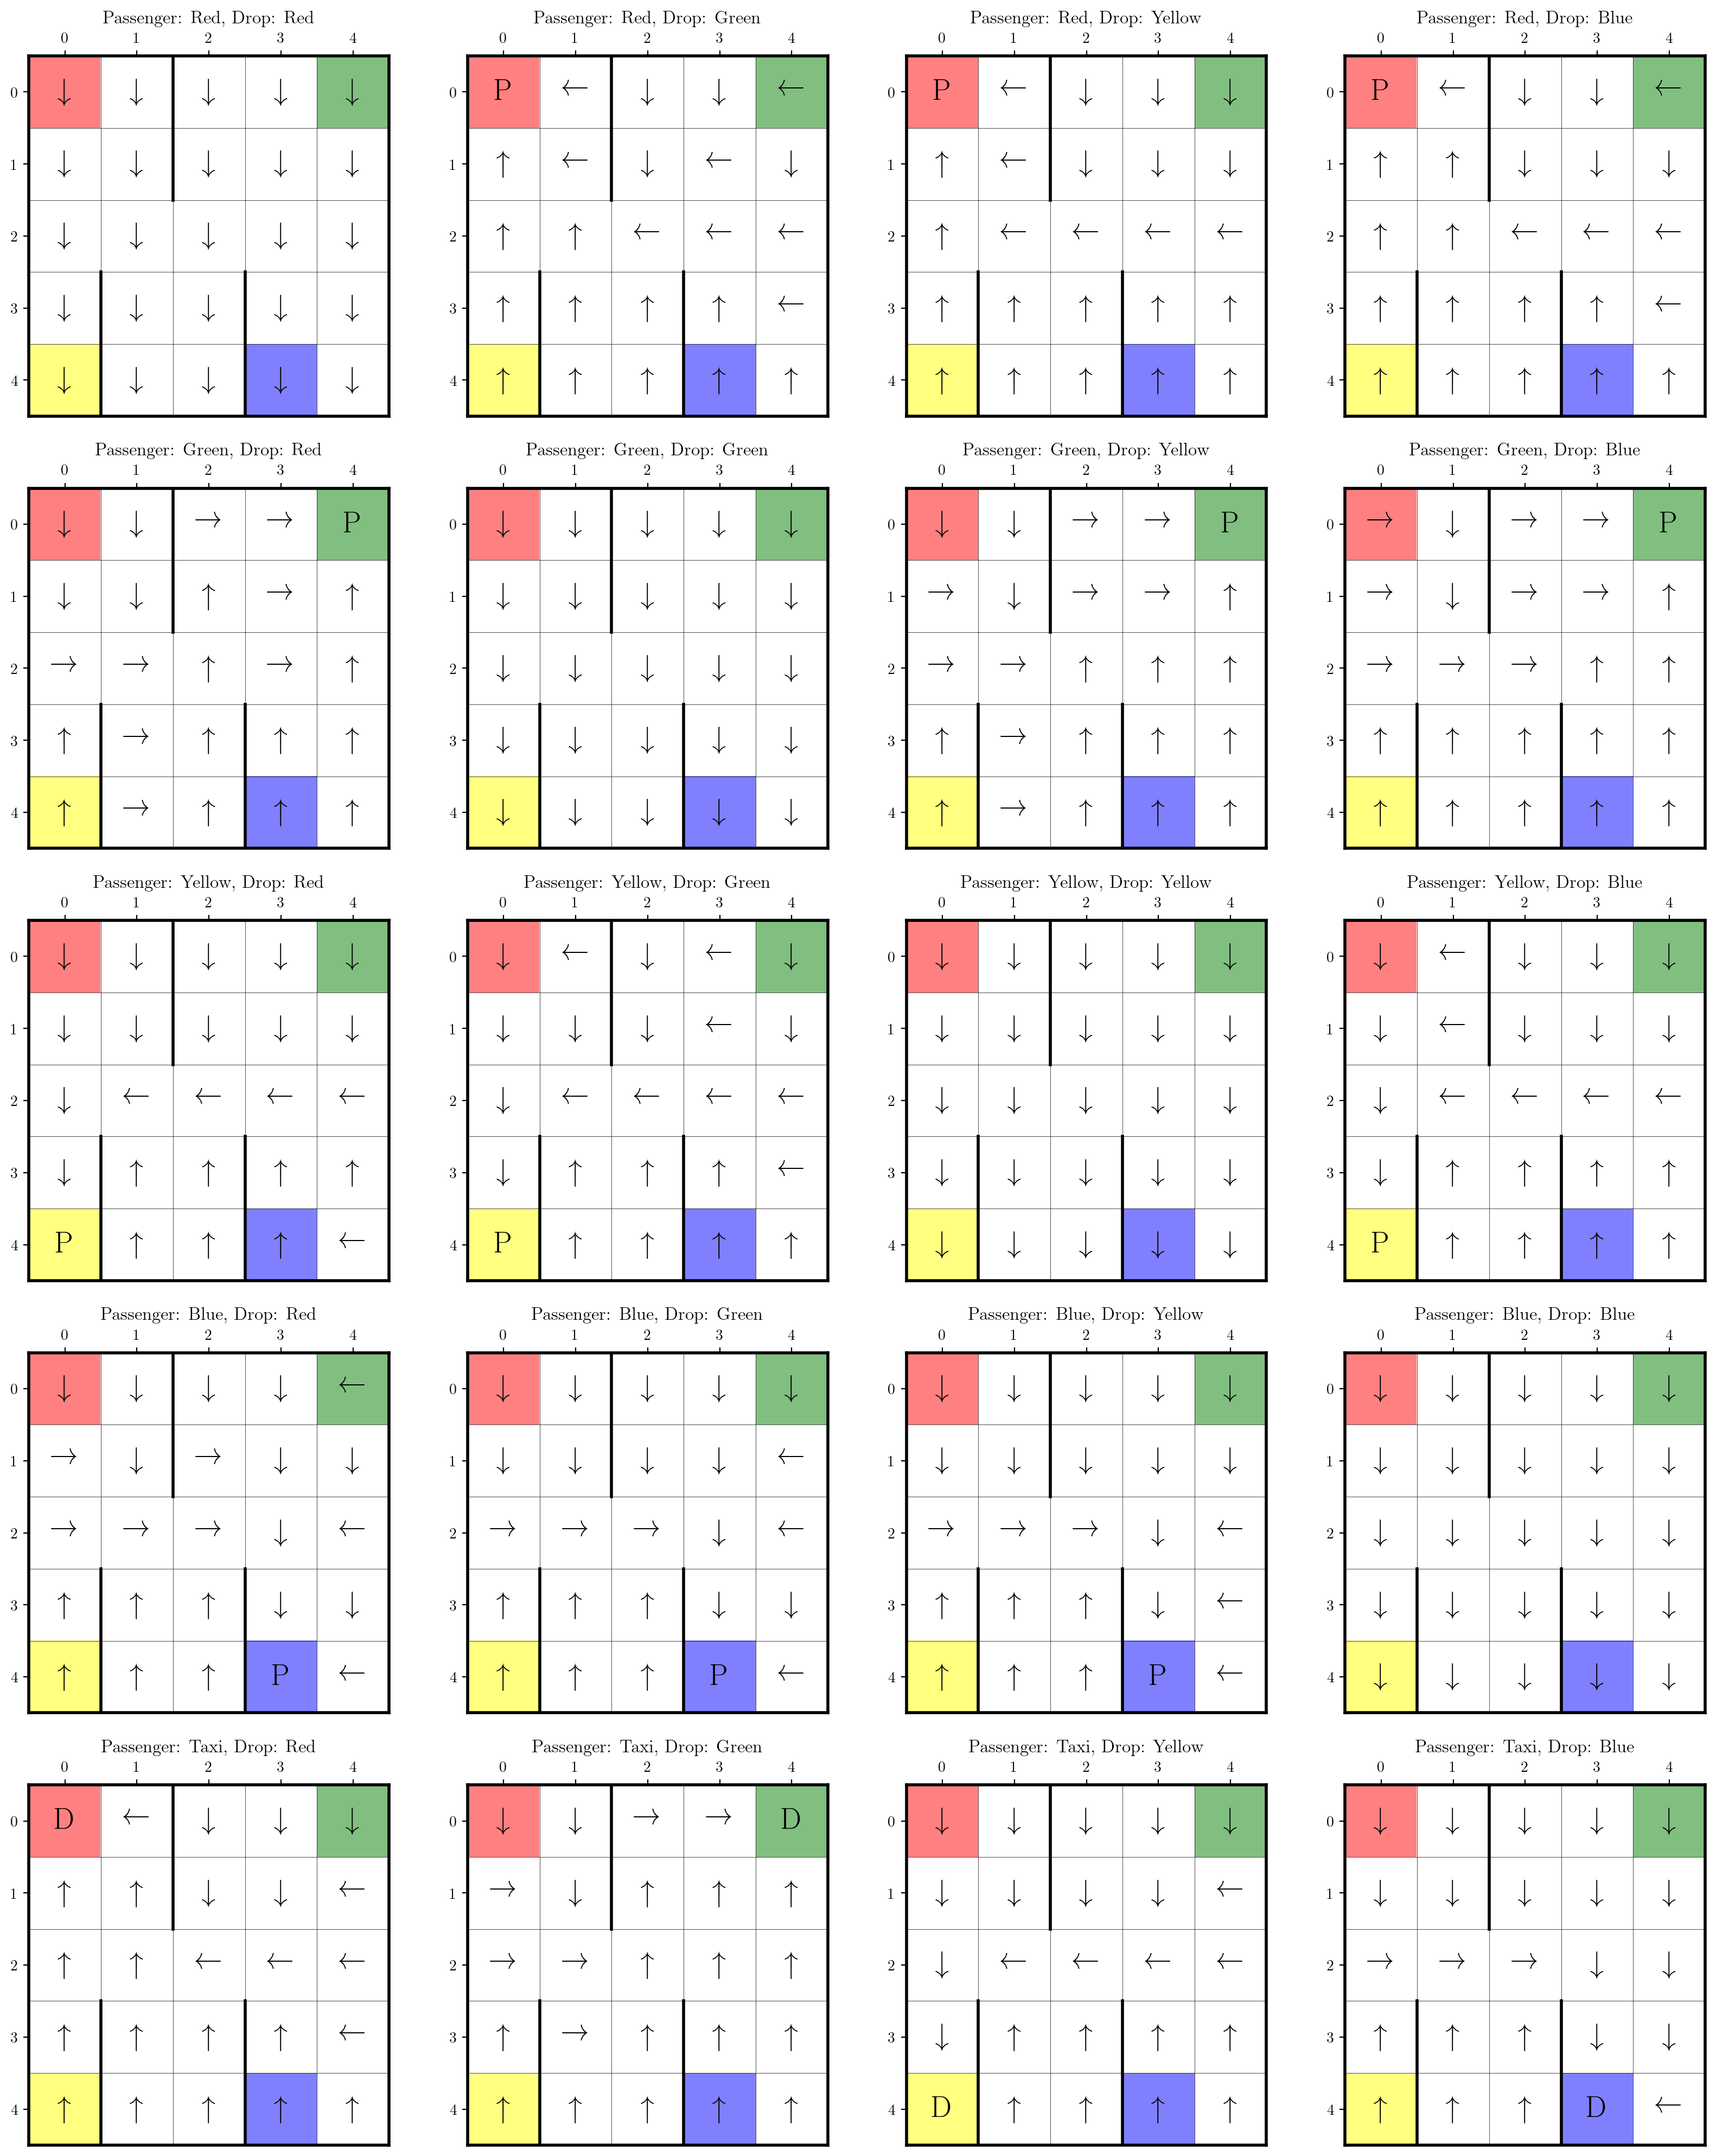

In [31]:
plot_Q = Q_Intra

grid = np.zeros((5, 5)).astype(int)
grid[0, 0] = 1
grid[0, 4] = 2
grid[4, 0] = 3
grid[4, 3] = 4

colors = ['white', 'red', 'green', 'yellow', 'blue']

pickup = [0, 1, 2, 3, 4]
drop = [0, 1, 2, 3]

fig, ax = plt.subplots(5, 4, figsize=(20, 25))
cmap = plt.cm.colors.ListedColormap(colors)
for p in pickup:
    for d in drop:
        states = []
        for x in range(nX):
            for y in range(nY):
                states.append(env.encode(x, y, p, d))
        states = np.array(states)
        assert len(states) == nX * nY

        ax[p, d].imshow(grid, cmap=cmap, interpolation='nearest', alpha=0.5)

        ax[p, d].axvline(x=0.5, ymin=0, ymax=2/5, color='black', linewidth=2)
        ax[p, d].axvline(x=2.5, ymin=0, ymax=2/5, color='black', linewidth=2)
        ax[p, d].axvline(x=1.5, ymin=3/5, ymax=1, color='black', linewidth=2)
        ax[p, d].axvline(x=0.5, color='black', linewidth=0.25)
        ax[p, d].axvline(x=1.5, color='black', linewidth=0.25)
        ax[p, d].axvline(x=2.5, color='black', linewidth=0.25)
        ax[p, d].axvline(x=3.5, color='black', linewidth=0.25)
        ax[p, d].axvline(x=4.5, color='black', linewidth=0.25)

        ax[p, d].axhline(y=0.5, color='black', linewidth=0.25)
        ax[p, d].axhline(y=1.5, color='black', linewidth=0.25)
        ax[p, d].axhline(y=2.5, color='black', linewidth=0.25)
        ax[p, d].axhline(y=3.5, color='black', linewidth=0.25)
        ax[p, d].axhline(y=4.5, color='black', linewidth=0.25)

        ax[p, d].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

        for state in states:
            i, j, _, _ = env.decode(state)
            action = np.argmax(plot_Q[state])
            if action < 6:
                ax[p, d].text(j, i, actions_map[action], ha='center', va='center', fontsize=20)
            else:
                ax[p, d].text(j, i, actions_map[action], ha='center', va='center', fontsize=10)

        ax[p, d].set_title(f"Passenger: {locations[p]}, Drop: {locations[d]}")

plt.savefig(f"plots/Q_Intra_{mode}.pdf", bbox_inches='tight')